<a href="https://colab.research.google.com/github/ChangeEngine/Intro-to-ML--Group-1--Final-Project/blob/main/notebooks/04_cnn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from pathlib import Path
import sys

REPO_URL = "https://github.com/ChangeEngine/Intro-to-ML--Group-1--Final-Project.git"
REPO_DIR = Path("/content/Intro-to-ML--Group-1--Final-Project")

if "google.colab" in sys.modules:
    if not REPO_DIR.exists():
        !git clone $REPO_URL $REPO_DIR
    os.chdir(REPO_DIR)

print("Working directory:", Path.cwd())


Cloning into '/content/Intro-to-ML--Group-1--Final-Project'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 93 (delta 34), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (93/93), 12.69 MiB | 14.28 MiB/s, done.
Resolving deltas: 100% (34/34), done.
Working directory: /content/Intro-to-ML--Group-1--Final-Project


In [2]:
from pathlib import Path

DATA_DIR = Path("data")
if not DATA_DIR.exists():
    alt = Path("..") / "data"
    if alt.exists():
        DATA_DIR = alt
    else:
        raise FileNotFoundError(
            "Could not find data/ at ./data or ../data. "
            "Make sure the repo has the MNIST .gz files."
        )

print("Using data folder:", DATA_DIR.resolve())
print("Files in data/:")
for p in DATA_DIR.iterdir():
    print(" -", p.name)


Using data folder: /content/Intro-to-ML--Group-1--Final-Project/data
Files in data/:
 - train-labels.idx1-ubyte.gz
 - t10k-labels.idx1-ubyte.gz
 - train-images.idx3-ubyte.gz
 - t10k-images.idx3-ubyte.gz


In [3]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

plt.rcParams["figure.figsize"] = (4, 4)

train_images_path = DATA_DIR / "train-images.idx3-ubyte.gz"
train_labels_path = DATA_DIR / "train-labels.idx1-ubyte.gz"
test_images_path  = DATA_DIR / "t10k-images.idx3-ubyte.gz"
test_labels_path  = DATA_DIR / "t10k-labels.idx1-ubyte.gz"

(train_images_path, train_labels_path, test_images_path, test_labels_path)


(PosixPath('data/train-images.idx3-ubyte.gz'),
 PosixPath('data/train-labels.idx1-ubyte.gz'),
 PosixPath('data/t10k-images.idx3-ubyte.gz'),
 PosixPath('data/t10k-labels.idx1-ubyte.gz'))

In [6]:
def load_mnist_images(path):
    with gzip.open(path, "rb") as f:
        data = f.read()

    header = np.frombuffer(data[:16], dtype=">i4")
    magic, num_images, rows, cols = header
    assert magic == 2051, "Not an images file"

    images = np.frombuffer(data[16:], dtype=np.uint8)
    images = images.reshape(num_images, rows, cols)
    return images


def load_mnist_labels(path):
    with gzip.open(path, "rb") as f:
        data = f.read()

    header = np.frombuffer(data[:8], dtype=">i4")
    magic, num_labels = header
    assert magic == 2049, "Not a labels file"

    labels = np.frombuffer(data[8:], dtype=np.uint8)
    return labels


def load_mnist_dataset(images_path, labels_path, normalize=True):
    X = load_mnist_images(images_path)
    y = load_mnist_labels(labels_path)

    if normalize:
        X = X.astype("float32") / 255.0

    return X, y


In [7]:
# Load
X_train, y_train = load_mnist_dataset(train_images_path, train_labels_path)
X_test, y_test   = load_mnist_dataset(test_images_path, test_labels_path)

print("X_train:", X_train.shape, X_train.dtype)
print("y_train:", y_train.shape, y_train.dtype)
print("X_test :", X_test.shape, X_test.dtype)
print("y_test :", y_test.shape, y_test.dtype)

# CNN expects (n_samples, height, width, channels)
X_train_cnn = X_train[..., np.newaxis]   # (60000, 28, 28, 1)
X_test_cnn  = X_test[..., np.newaxis]    # (10000, 28, 28, 1)

print("X_train_cnn:", X_train_cnn.shape)
print("X_test_cnn :", X_test_cnn.shape)

# Train/validation split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_cnn,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train,
)

print("Train subset:", X_tr.shape, y_tr.shape)
print("Val subset  :", X_val.shape, y_val.shape)


X_train: (60000, 28, 28) float32
y_train: (60000,) uint8
X_test : (10000, 28, 28) float32
y_test : (10000,) uint8
X_train_cnn: (60000, 28, 28, 1)
X_test_cnn : (10000, 28, 28, 1)
Train subset: (48000, 28, 28, 1) (48000,)
Val subset  : (12000, 28, 28, 1) (12000,)


In [8]:
input_shape = (28, 28, 1)
num_classes = 10

model = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="softmax"),
])

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=3,
        restore_best_weights=True,
    )
]

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=128,
    callbacks=callbacks,
    verbose=2,
)


Epoch 1/15
375/375 - 22s - 59ms/step - accuracy: 0.9342 - loss: 0.2259 - val_accuracy: 0.9785 - val_loss: 0.0745
Epoch 2/15
375/375 - 21s - 56ms/step - accuracy: 0.9812 - loss: 0.0602 - val_accuracy: 0.9841 - val_loss: 0.0525
Epoch 3/15
375/375 - 20s - 54ms/step - accuracy: 0.9872 - loss: 0.0411 - val_accuracy: 0.9853 - val_loss: 0.0480
Epoch 4/15
375/375 - 21s - 55ms/step - accuracy: 0.9907 - loss: 0.0310 - val_accuracy: 0.9853 - val_loss: 0.0468
Epoch 5/15
375/375 - 41s - 108ms/step - accuracy: 0.9925 - loss: 0.0245 - val_accuracy: 0.9888 - val_loss: 0.0403
Epoch 6/15
375/375 - 21s - 56ms/step - accuracy: 0.9935 - loss: 0.0211 - val_accuracy: 0.9890 - val_loss: 0.0418
Epoch 7/15
375/375 - 20s - 53ms/step - accuracy: 0.9947 - loss: 0.0161 - val_accuracy: 0.9862 - val_loss: 0.0464
Epoch 8/15
375/375 - 21s - 57ms/step - accuracy: 0.9958 - loss: 0.0134 - val_accuracy: 0.9883 - val_loss: 0.0434
Epoch 9/15
375/375 - 21s - 57ms/step - accuracy: 0.9970 - loss: 0.0094 - val_accuracy: 0.9879 -

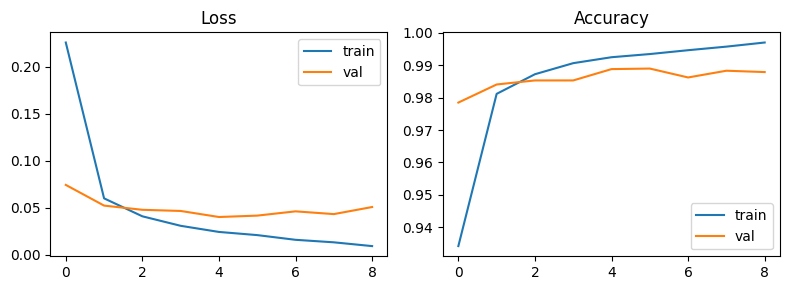

In [10]:
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
# Validation predictions
y_val_prob = model.predict(X_val)
y_val_pred = np.argmax(y_val_prob, axis=1)

val_acc = accuracy_score(y_val, y_val_pred)
val_f1_macro = f1_score(y_val, y_val_pred, average="macro")
val_f1_weighted = f1_score(y_val, y_val_pred, average="weighted")

print("VALIDATION RESULTS (CNN)")
print("Accuracy      :", val_acc)
print("F1 (macro)    :", val_f1_macro)
print("F1 (weighted) :", val_f1_weighted)
print("\nClassification report (validation):\n")
print(classification_report(y_val, y_val_pred))

# Test predictions
y_test_prob = model.predict(X_test_cnn)
y_test_pred = np.argmax(y_test_prob, axis=1)

test_acc = accuracy_score(y_test, y_test_pred)
test_f1_macro = f1_score(y_test, y_test_pred, average="macro")
test_f1_weighted = f1_score(y_test, y_test_pred, average="weighted")

print("\nTEST RESULTS (CNN)")
print("Accuracy      :", test_acc)
print("F1 (macro)    :", test_f1_macro)
print("F1 (weighted) :", test_f1_weighted)


375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step
VALIDATION RESULTS (CNN)
Accuracy      : 0.989
F1 (macro)    : 0.9889298505863364
F1 (weighted) : 0.9889979434427795

Classification report (validation):

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1185
           1       0.99      1.00      0.99      1348
           2       0.99      0.99      0.99      1192
           3       0.99      0.99      0.99      1226
           4       0.99      0.98      0.98      1168
           5       0.99      0.99      0.99      1084
           6       0.99      0.99      0.99      1184
           7       0.99      0.99      0.99      1253
           8       0.99      0.98      0.98      1170
           9       0.98      0.99      0.98      1190

    accuracy                           0.99     12000
   macro avg       0.99      0.99      0.99     12000
weighted avg       0.99      0.99      0.99     12000

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step

TE

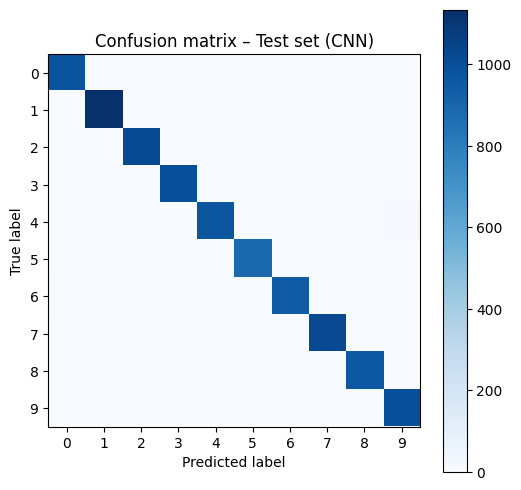

In [12]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion matrix – Test set (CNN)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.show()
